# DSCI 552 Homework 4

#### Name: Boyu Shen
#### Github username: boyushen0701
#### USC ID: 3547352504

In [311]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.utils import resample
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download the AReM data

In [312]:
# get all names of activities
activities=["bending1","bending2","cycling","lying","sitting","standing","walking"]

In [313]:
# define data loading
def read_data(path):
    return pd.read_csv(path,skiprows=4,usecols=range(1,7))

In [314]:
# get train and test datapaths
col = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
totaldatapath = set(['dataset{0}.csv'.format(x) for x in range(1,16)])
testdatapath_1 = set(['dataset1.csv','dataset2.csv'])
testdatapath_2 = set(['dataset1.csv','dataset2.csv','dataset3.csv'])
traindatapath_1 = totaldatapath-testdatapath_1
traindatapath_2 = totaldatapath-testdatapath_2

### (b) Split training and test datasets

In [315]:
# get train and test dataset lists
traindata=[]
testdata=[]
train_dict = {}
test_dict = {}

# get train and test datasets for folder bending1 and bending2
for activity in activities[:2]:
    path="../data/AReM/{0}".format(activity)
    for file in os.listdir(path):
        # get rid of the dilimiter problem
        if activity == 'bending2' and file == 'dataset4.csv':
            df = pd.read_csv('../data/AReM/bending2/dataset4.csv',skiprows=4,delim_whitespace=True).reset_index()
            df.columns = col
            df = df.drop(columns=['time'])
            train_dict[activity+' '+file] = df
            traindata.append(df)
           
        else:
            if file in testdatapath_1:
                df = read_data("../data/AReM/{0}/{1}".format(activity,file))
                test_dict[activity+' '+file] = df
                testdata.append(df)
            if file in traindatapath_1:
                df = read_data("../data/AReM/{0}/{1}".format(activity,file))
                train_dict[activity+' '+file] = df    
                traindata.append(df)
                
# get train and test datasets for other folders
for activity in activities[2:]:
    path="../data/AReM/{0}".format(activity)
    for file in os.listdir(path):
        if file in testdatapath_2:
            df = read_data("../data/AReM/{0}/{1}".format(activity,file))
            test_dict[activity+' '+file] = df
            testdata.append(df)
        if file in traindatapath_2:
            df = read_data("../data/AReM/{0}/{1}".format(activity,file))
            train_dict[activity+' '+file] = df
            traindata.append(df)

### (c) Feature Extraction

#### i. Research what types of time-domain features are usually used in time series classification and list them. 

means, standard deviations, skewness, Kurtosis, max and min values

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. 

In [316]:
# get all datasets
all_data = traindata + testdata

In [317]:
# define function to extract features
def add_feature(df, index, lst):
    minimum = df.min()[index]
    lst.append(minimum)
    maximum = df.max()[index]
    lst.append(maximum)
    mean = df.mean()[index]
    lst.append(mean)
    median = df.median()[index]
    lst.append(median)
    std = df.std()[index]
    lst.append(std)
    firstquart = df.quantile(q = 0.25)[index]
    lst.append(firstquart)
    thirdquart = df.quantile(q = 0.75)[index]
    lst.append(thirdquart) 

In [318]:
# get column names and time features names
cols=["min1","max1","mean1","median1","std1","1stQuart1","3rdQuart1",
     "min2","max2","mean2","median2","std2","1stQuart2","3rdQuart2", 
     "min3","max3","mean3","median3","std3","1stQuart3","3rdQuart3",
     "min4","max4","mean4","median4","std4","1stQuart4","3rdQuart4", 
     "min5","max5","mean5","median5","std5","1stQuart5","3rdQuart5", 
     "min6","max6","mean6","median6","std6","1stQuart6","3rdQuart6"]

time_series = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
feature_df = pd.DataFrame(columns = cols)

# extract features for each instance 
for df in all_data:
    lst = []
    for i in range(len(time_series)):
        add_feature(df, i, lst)
    s = pd.Series(lst, index=cols)
    feature_df = feature_df.append(s,ignore_index=True)

feature_df

,min1,max1,mean1,median1,std1,1stQuart1,3rdQuart1,min2,max2,mean2,...,std5,1stQuart5,3rdQuart5,min6,max6,mean6,median6,std6,1stQuart6,3rdQuart6
0,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.750,0.0,2.96,0.555313,0.490,0.487826,0.000,0.830
1,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.000,0.0,5.26,0.679646,0.500,0.622534,0.430,0.870
2,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.330,0.0,2.18,0.613521,0.500,0.524317,0.000,1.000
3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.250,0.0,1.79,0.383292,0.430,0.389164,0.000,0.500
4,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.500,0.0,1.79,0.493292,0.430,0.513506,0.000,0.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,35.50,46.25,43.174938,43.670,1.989052,42.50,44.5000,0.0,2.12,0.506583,...,2.983976,12.7500,16.500,0.0,5.72,0.911979,0.830,0.666161,0.470,1.220
84,32.75,47.00,42.760563,44.500,3.398919,41.33,45.3725,0.0,3.34,0.486167,...,4.296574,13.0000,18.565,0.0,5.73,0.842271,0.710,0.722165,0.430,1.090
85,19.33,43.50,34.227771,35.500,4.889576,30.50,37.7500,0.0,14.50,3.995729,...,3.092094,14.7500,18.670,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425
86,12.50,45.00,33.509729,34.125,4.850923,30.50,36.7500,0.0,13.05,4.450771,...,3.133564,14.6275,18.750,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440


#### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [319]:
# get the standard deviation for each time_domain
feature_sd = feature_df.describe()[feature_df.describe().index == 'std'].T

In [320]:
# write function to change the feature names
index = list(feature_sd.index)
def get_feature_name(string):
    string_dict = {'1':'_avg_rss12', '2':'_var_rss12', '3':'_avg_rss13', 
                   '4':'_var_rss13', '5':'_avg_rss23', '6':'_var_rss23'}
    return string[:-1]+string_dict[list(string)[-1]]

In [321]:
# get new feature index
feature_lst = []
for i in index:
    feature_lst.append(get_feature_name(i))
    
feature_sd.index = feature_lst
feature_sd

,std
min_avg_rss12,9.569975
max_avg_rss12,4.394362
mean_avg_rss12,5.335718
median_avg_rss12,5.440054
std_avg_rss12,1.772153
1stQuart_avg_rss12,6.153590
3rdQuart_avg_rss12,5.138925
min_var_rss12,0.000000
max_var_rss12,5.062729
mean_var_rss12,1.574164


In [322]:
# build 90% bootstrap confidence interval with 1000 iterations
n_iterations = 1000
lower={}
upper={}
for i in feature_df.columns.tolist():
    bootstrap = []
    for p in range(n_iterations):
        sample = resample(feature_df[i])
        bootstrap.append(np.std(sample))
    bootstrap.sort()
    lower[i] = bootstrap[49]
    upper[i] = bootstrap[949]

In [323]:
# add lower bound and upper bound for each feature
lower_ci = pd.Series(lower)
lower_ci.index = feature_sd.index
upper_ci = pd.Series(upper)
upper_ci.index = feature_sd.index
feature_sd["lower bound"] = lower_ci
feature_sd["upper bound"] = upper_ci
feature_sd

,std,lower bound,upper bound
min_avg_rss12,9.569975,8.142286,10.672282
max_avg_rss12,4.394362,3.274749,5.269408
mean_avg_rss12,5.335718,4.656655,5.846540
median_avg_rss12,5.440054,4.748134,5.928860
std_avg_rss12,1.772153,1.567771,1.937674
1stQuart_avg_rss12,6.153590,5.533467,6.592781
3rdQuart_avg_rss12,5.138925,4.333611,5.800974
min_var_rss12,0.000000,0.000000,0.000000
max_var_rss12,5.062729,4.586937,5.372056
mean_var_rss12,1.574164,1.383009,1.688359


#### iv. Use your judgement to select the three most important time-domain features.

Mean: It gives the average or the most common value in the time series.
<br><br>Median: It measures the middle value of a sorted list of time series. One advantage is that it is not affected by extreme values.
<br><br>Standard Deviation: It shows how much data is clustered around a mean value. We can get an idea of how the time series data is distributed.

### Time Series Classification Part 2: Binary and Multiclass Classification

#### (a) i. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6.

In [324]:
# given the value, find the corresponding key
def get_key(mydict, val):
    for key, value in mydict.items():
         if val is value:
            return key

In [325]:
cols=["min1","max1","mean1","median1","std1","1stQuart1","3rdQuart1",
     "min2","max2","mean2","median2","std2","1stQuart2","3rdQuart2", 
     "min3","max3","mean3","median3","std3","1stQuart3","3rdQuart3",
     "min4","max4","mean4","median4","std4","1stQuart4","3rdQuart4", 
     "min5","max5","mean5","median5","std5","1stQuart5","3rdQuart5", 
     "min6","max6","mean6","median6","std6","1stQuart6","3rdQuart6","activity"]

time_series = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_df = pd.DataFrame(columns = cols)
test_df = pd.DataFrame(columns = cols)

# extract features for each instance in training data
for df in traindata:
    lst = []
    for i in range(len(time_series)):
        add_feature(df, i, lst)
    if 'bending' in get_key(train_dict, df).split(' ')[0]:
        lst.append('bending')
    else:
        lst.append('non-bending')  
    s = pd.Series(lst, index=cols)
    train_df = train_df.append(s,ignore_index=True)

# extract features for each instance in test data
for df in testdata:
    lst = []
    for i in range(len(time_series)):
        add_feature(df, i, lst)
    if 'bending' in get_key(test_dict, df).split(' ')[0]:
        lst.append('bending')
    else:
        lst.append('non-bending')  
    s = pd.Series(lst, index=cols)
    test_df = test_df.append(s,ignore_index=True)

In [326]:
# update the column names for training dataset
train_col = [get_feature_name(i) for i in train_df.columns[:-1]]
train_col.append('activity')
train_df.columns = train_col

In [327]:
# a dataframe contains all training data
train_df

,min_avg_rss12,max_avg_rss12,mean_avg_rss12,median_avg_rss12,std_avg_rss12,1stQuart_avg_rss12,3rdQuart_avg_rss12,min_var_rss12,max_var_rss12,mean_var_rss12,...,1stQuart_avg_rss23,3rdQuart_avg_rss23,min_var_rss23,max_var_rss23,mean_var_rss23,median_var_rss23,std_var_rss23,1stQuart_var_rss23,3rdQuart_var_rss23,activity
0,36.25,48.00,43.969125,44.500,1.618364,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.00,2.96,0.555313,0.490,0.487826,0.0000,0.8300,bending
1,37.00,48.00,43.454958,43.250,1.386098,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700,bending
2,33.00,47.75,42.179813,43.500,3.670666,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000,bending
3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000,bending
4,35.00,47.40,43.954500,44.330,1.558835,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.00,1.79,0.493292,0.430,0.513506,0.0000,0.9400,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,19.75,45.50,34.322750,35.250,4.752477,31.00,38.00,0.0,13.47,4.456333,...,13.5000,17.75,0.00,9.67,3.432562,3.200,1.732727,2.1575,4.5650,non-bending
65,19.25,44.00,34.473188,35.000,4.796705,31.25,38.00,0.0,13.86,4.359312,...,13.7300,17.75,0.43,9.00,3.340458,3.090,1.699114,2.1200,4.3750,non-bending
66,23.50,46.25,34.873229,35.250,4.531720,31.75,38.25,0.0,14.82,4.380583,...,13.7500,18.00,0.00,9.51,3.424646,3.270,1.690960,2.1700,4.5000,non-bending
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.00,0.0,15.37,4.398833,...,14.0000,18.25,0.00,8.86,3.289542,3.015,1.680170,2.1200,4.2600,non-bending


In [328]:
# update the column names for test dataset
test_col = [get_feature_name(i) for i in test_df.columns[:-1]]
test_col.append('activity')
test_df.columns = test_col

In [329]:
# a dataframe contains all test data
test_df

,min_avg_rss12,max_avg_rss12,mean_avg_rss12,median_avg_rss12,std_avg_rss12,1stQuart_avg_rss12,3rdQuart_avg_rss12,min_var_rss12,max_var_rss12,mean_var_rss12,...,1stQuart_avg_rss23,3rdQuart_avg_rss23,min_var_rss23,max_var_rss23,mean_var_rss23,median_var_rss23,std_var_rss23,1stQuart_var_rss23,3rdQuart_var_rss23,activity
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,non-bending
5,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,non-bending
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,non-bending
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363688,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,non-bending
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,non-bending
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,non-bending


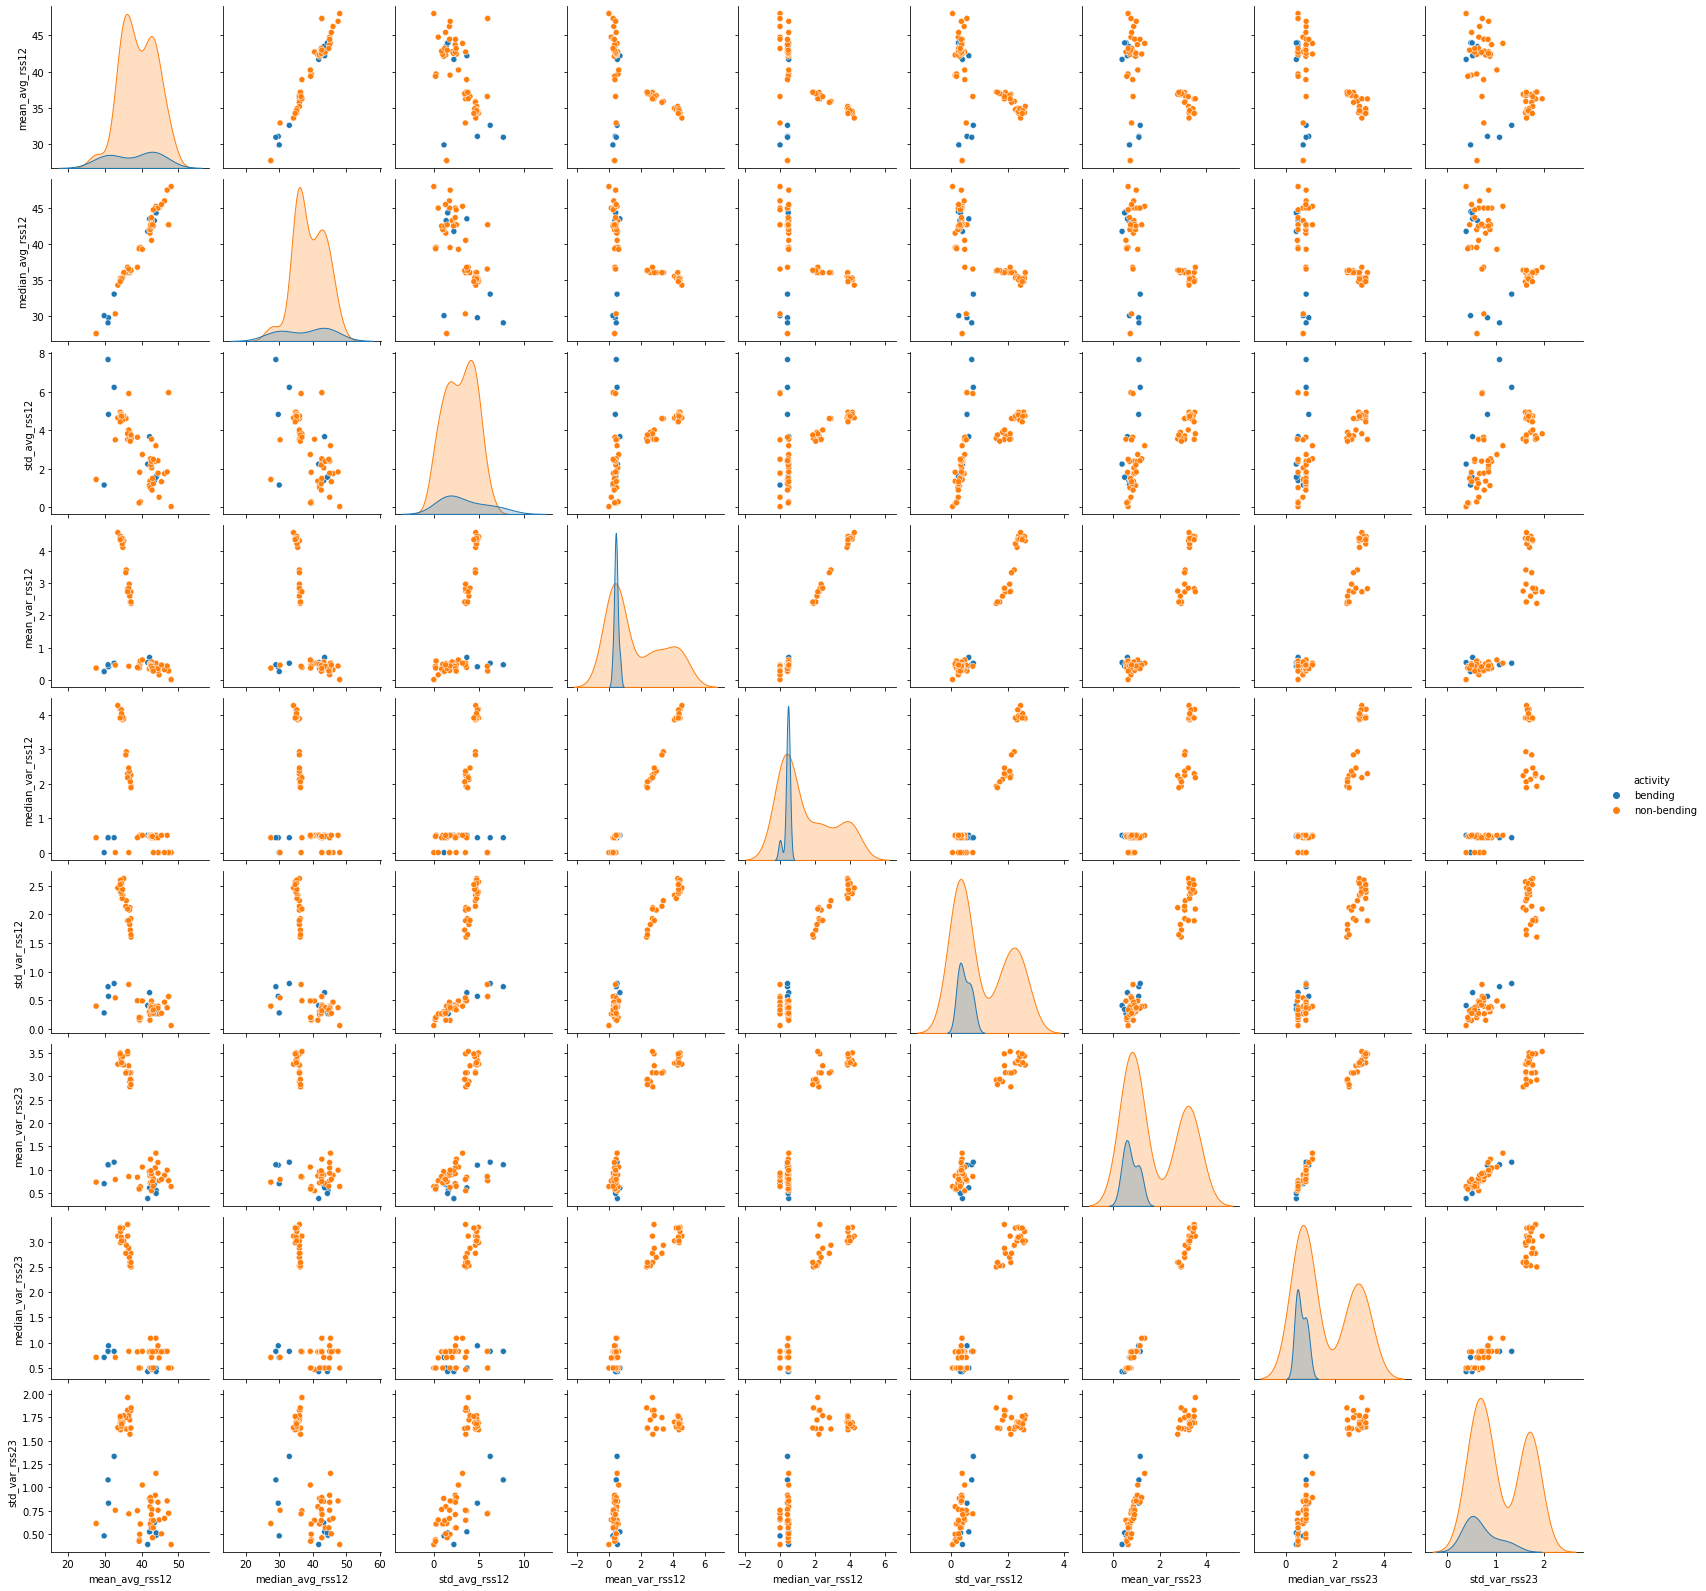

In [330]:
# draw the scatter pairplot using the extracted features
sns.pairplot(data=train_df, hue='activity', 
             vars= ['mean_avg_rss12', 'median_avg_rss12', 'std_avg_rss12','mean_var_rss12', 
                    'median_var_rss12', 'std_var_rss12', 'mean_var_rss23', 'median_var_rss23', 
                    'std_var_rss23'])
plt.show()

#### ii. Break each time series in your training set into two (approximately) equal length time series. 

In [331]:
cols=["min1","max1","mean1","median1","std1","1stQuart1","3rdQuart1",
     "min2","max2","mean2","median2","std2","1stQuart2","3rdQuart2", 
     "min3","max3","mean3","median3","std3","1stQuart3","3rdQuart3",
     "min4","max4","mean4","median4","std4","1stQuart4","3rdQuart4", 
     "min5","max5","mean5","median5","std5","1stQuart5","3rdQuart5", 
     "min6","max6","mean6","median6","std6","1stQuart6","3rdQuart6","activity"]

time_series = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

# create two empty dataframes
train_df_1 = pd.DataFrame(columns = cols)
train_df_2 = pd.DataFrame(columns = cols)

# extract features for each instance in training data
for df in traindata:
    lst_1 = []
    lst_2 = []
    for i in range(len(time_series)):
        # split dataset into two equal length time series
        add_feature(df[:240], i, lst_1)
        add_feature(df[240:], i, lst_2) 
    if 'bending' in get_key(train_dict, df).split(' ')[0]:
        lst_1.append('bending')
        lst_2.append('bending')
    else:
        lst_1.append('non-bending')
        lst_2.append('non-bending')
    s_1 = pd.Series(lst_1, index=cols)
    s_2 = pd.Series(lst_2, index=cols)
    train_df_1 = train_df_1.append(s_1,ignore_index=True)
    select_lst_1 = ['mean1','median1','std1','mean2','median2','std2','mean6','median6','std6']
    select_lst_2 = ['mean1','median1','std1','mean2','median2','std2','mean6','median6','std6','activity']
    train_df_1 = train_df_1[select_lst_1]
    train_df_2 = train_df_2.append(s_2,ignore_index=True)
    train_df_2 = train_df_2[select_lst_2]

# concatenate two dataframes column-wise
new_train_df = pd.concat([train_df_1, train_df_2], axis=1)

In [332]:
# change column names
new_train_col = ['mean1', 'median1', 'std1', 'mean2', 'median2', 'std2', 'mean6',
       'median6', 'std6', 'mean7', 'median7', 'std7', 'mean8', 'median8',
       'std8', 'mean12', 'median12', 'std12', 'activity']
new_train_df.columns = new_train_col

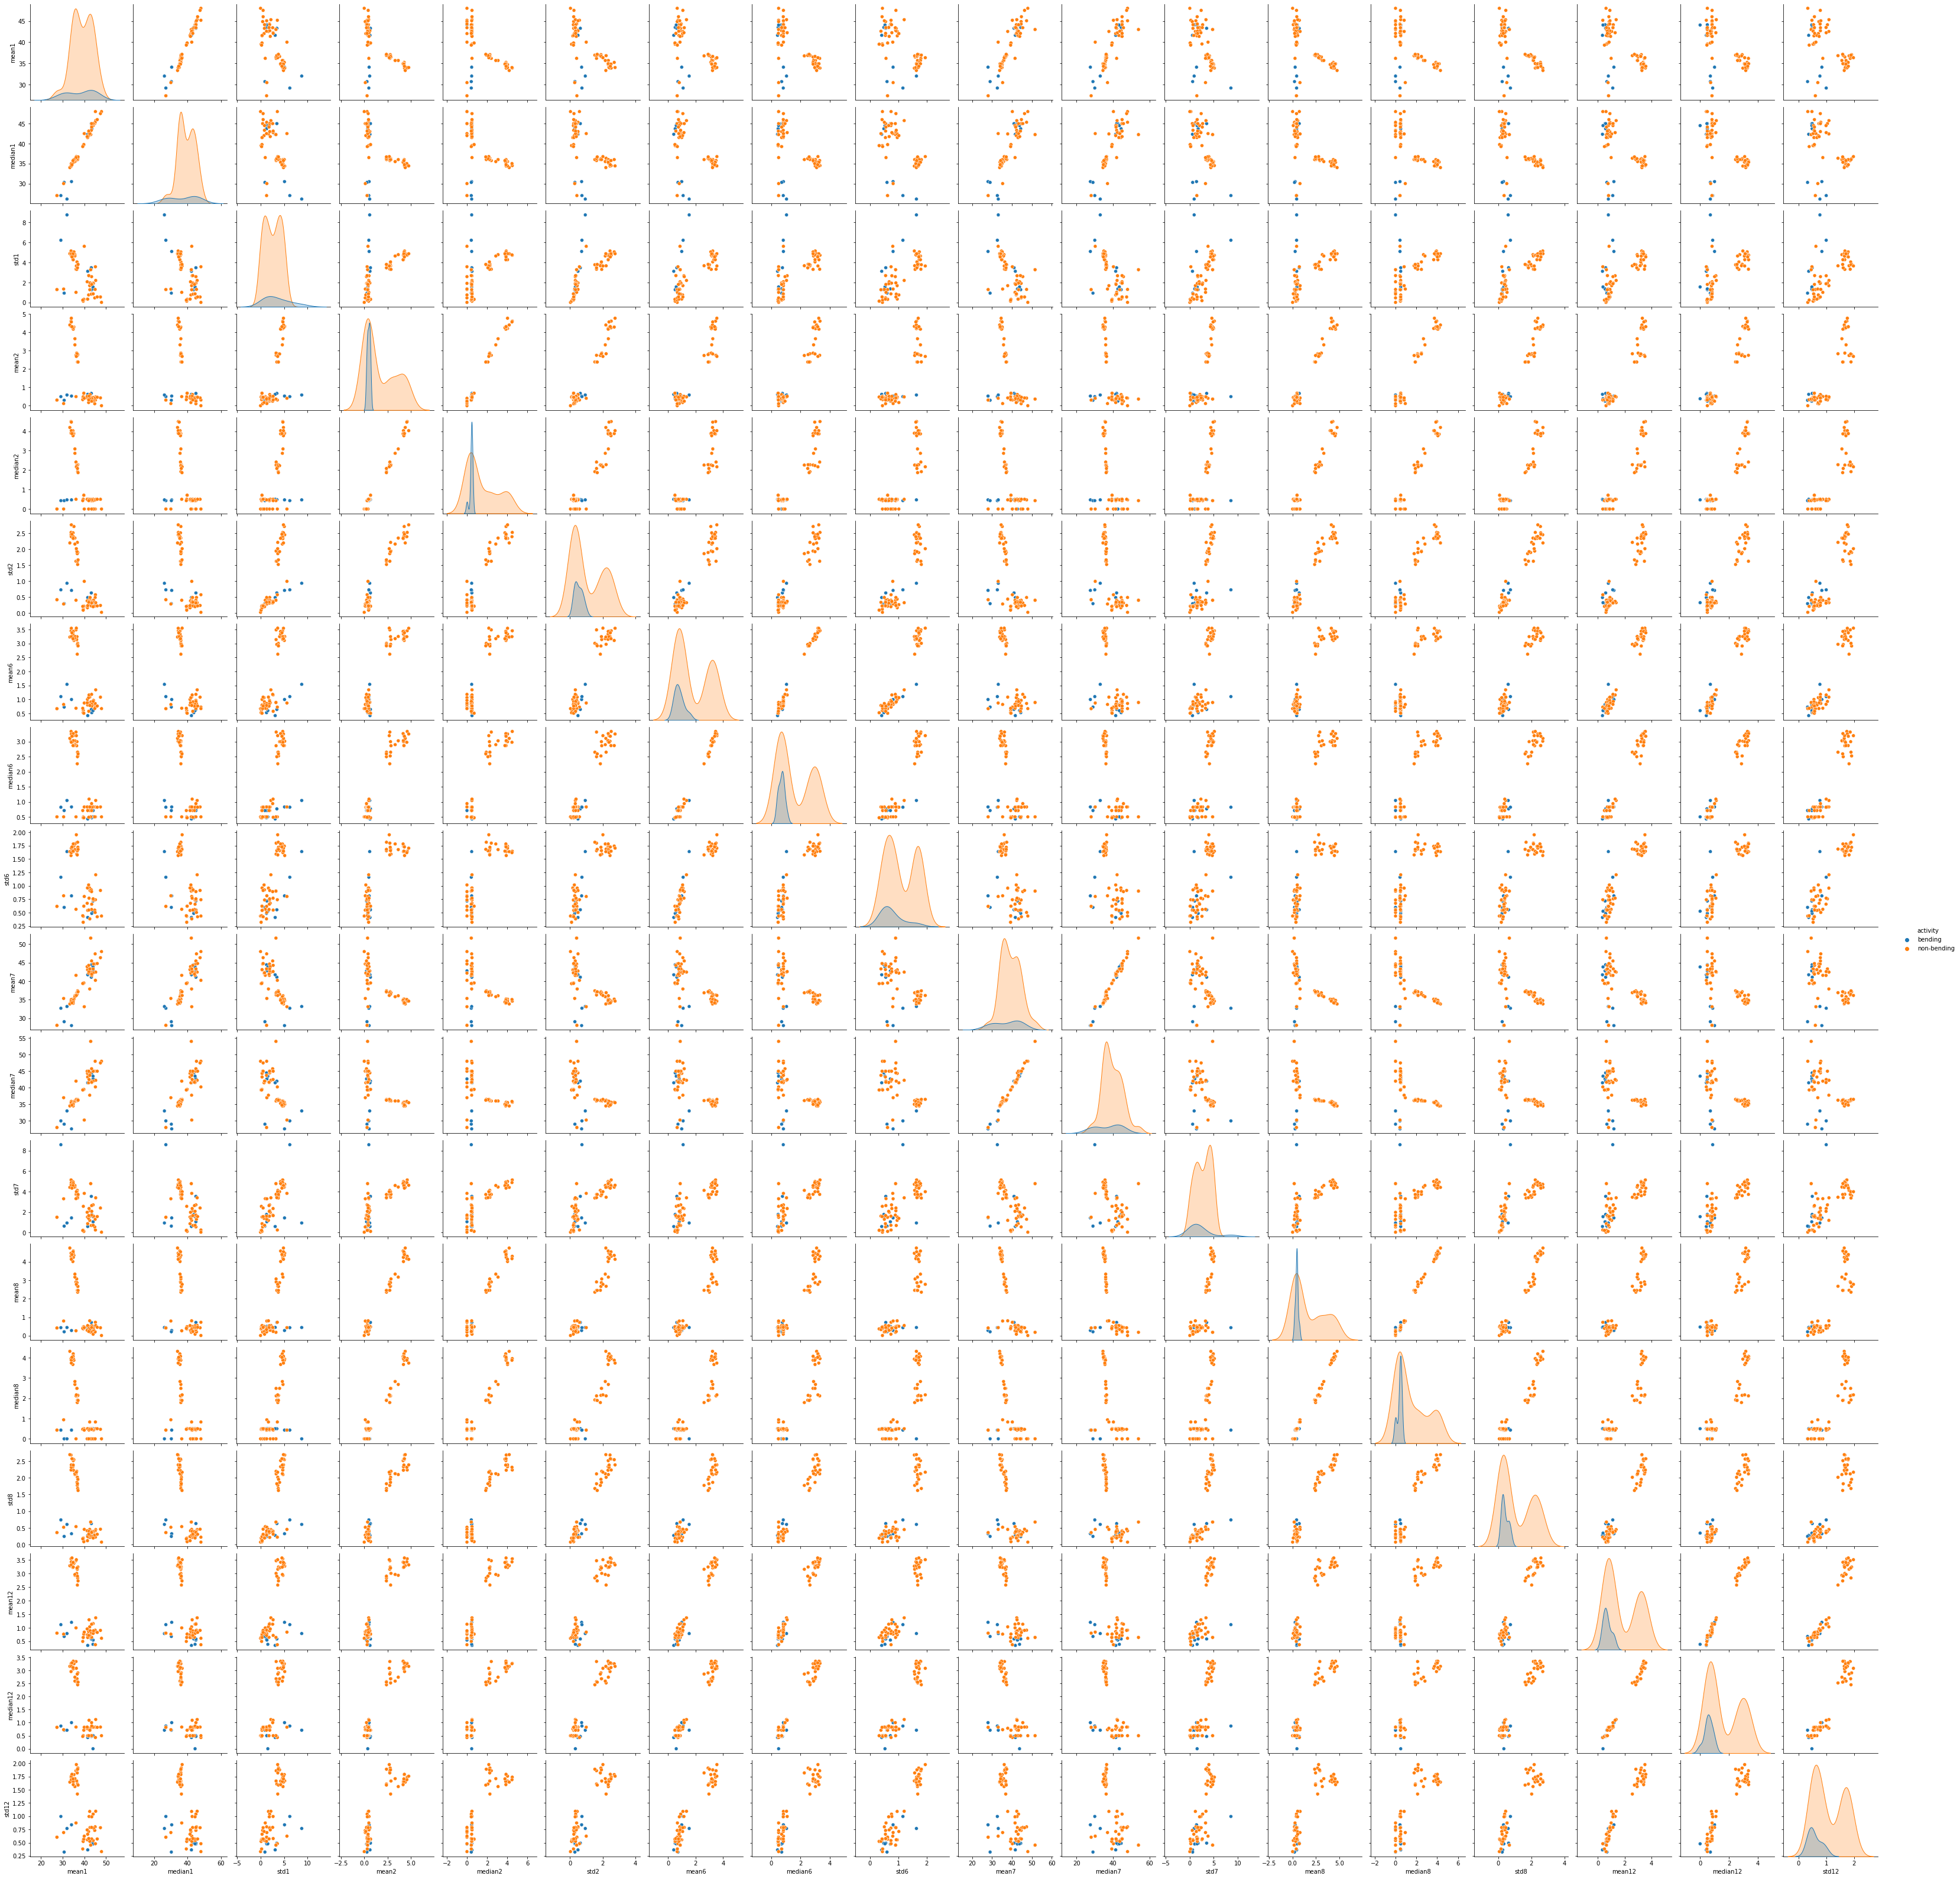

In [333]:
# draw the scatter pairplot using the extracted two sets of features
sns.pairplot(data=new_train_df, hue='activity', vars= new_train_col[:-1])
plt.show()

Compared to the graph I plot in d (i), I conclude that there are more non-bending data points compared to bending data points, but the overall shapes and graphs are similar.

#### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features.

In [334]:
# logistic regression on training data using the time domain features.
num_split = [i for i in range(1,21)]
features=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
feature_lst = ['mean_avg_rss12', 'median_avg_rss12', 'std_avg_rss12',
               'mean_var_rss12','median_var_rss12', 'std_var_rss12',
               'mean_avg_rss13','median_avg_rss13','std_avg_rss13',
               'mean_var_rss13','median_var_rss13','std_var_rss13',
               'mean_avg_rss23','median_avg_rss23','std_avg_rss23',
               'mean_var_rss23','median_var_rss23','std_var_rss23']

In [335]:
# create a function to calculate the accuracy for each number of split
def RFECV_selection(result_dict, num_split):
    new_dict = {}
    for f in features:
        new_dict['mean_'+f] = []
        new_dict['median_'+f] = []
        new_dict['std_'+f] = []
    new_dict['activity'] = []
    
    for df in traindata:
        df_split=np.array_split(df,num_split)
        for s in df_split:
            for f in features:
                new_dict["mean"+"_"+f].append(np.mean(s[f]))
                new_dict["median"+"_"+f].append(np.median(s[f]))
                new_dict["std"+"_"+f].append(s[f].std())
            if 'bending' in get_key(train_dict, df).split(' ')[0]:
                new_dict['activity'].append(1)
            else:
                new_dict['activity'].append(0)
                
    # get features for the training data
    df_train = pd.DataFrame(new_dict)
    X_train = df_train[feature_lst]
    y_train = np.array(df_train['activity']).reshape(-1)
    
    # fit the model
    model = LogisticRegression(solver='lbfgs', max_iter=10000, C=10000)
    rfecv = RFECV(model, cv = StratifiedKFold(5),scoring='accuracy',step = 1)
    rfecv.fit(X_train.values, y_train)
    best_features = list(X_train.columns[np.where(rfecv.support_ == True)[0]])
    train_score = max(rfecv.cv_results_['mean_test_score'])
    
    # add each attribute to the dictionary
    result_dict[num_split] = []
    result_dict[num_split].append(train_score)
    result_dict[num_split].append(rfecv.n_features_)
    result_dict[num_split].append(best_features)

###### About Model Selection:
I tuned the parameters of the logistic regression and set the C value to be 10000. In order to avoid putting too many weights on the complexity penalty, I set the C value to be as large as possible instead of the default value 1.0 to add more weights on my training data to remove the effect of L2 regularization,

In [336]:
# get attributes for each split
result_dict = {}
for i in num_split:
    RFECV_selection(result_dict, i)

In [337]:
# create output dataframe
output = pd.DataFrame(result_dict).T.reset_index()
output.columns = ['L', 'Score', 'Num_feature', 'Best_features']
output['Score'] = pd.to_numeric(output['Score'])
output

,L,Score,Num_feature,Best_features
0,1,0.928571,10,"[mean_avg_rss12, median_avg_rss12, mean_avg_rs..."
1,2,0.871164,16,"[mean_avg_rss12, median_avg_rss12, std_avg_rss..."
2,3,0.869686,1,[std_var_rss23]
3,4,0.887792,2,"[std_var_rss13, mean_var_rss23]"
4,5,0.860870,1,[std_var_rss13]
5,6,0.876991,12,"[mean_avg_rss12, mean_var_rss12, median_var_rs..."
6,7,0.863402,1,[std_var_rss13]
7,8,0.869582,1,[mean_var_rss23]
8,9,0.888877,5,"[mean_var_rss12, median_var_rss12, std_var_rss..."
9,10,0.885507,5,"[median_var_rss12, mean_var_rss13, std_var_rss..."


In [338]:
# print the output
output = output.iloc[output['Score'].idxmax()]
optimal_L = output[0]
cv_score = output[1]
num_features = output[2]
best_features = output[3]
print('The best value of L is: '+ str(optimal_L))
print('The score of the optimal L is: '+ str(cv_score))
print('The optimal number of features is: '+str(num_features))
print('The best features are: '+str(best_features))

The best value of L is: 1
The score of the optimal L is: 0.9285714285714285
The optimal number of features is: 10
The best features are: ['mean_avg_rss12', 'median_avg_rss12', 'mean_avg_rss13', 'median_avg_rss13', 'std_avg_rss13', 'median_var_rss13', 'mean_avg_rss23', 'std_avg_rss23', 'mean_var_rss23', 'median_var_rss23']


<u> Thus, my best pair of (L, p) is (1, 10). <u>

##### Wrong ways to perform cross-validation:
<br> 1. Combine training and test datasets, and find the highest correlated features with our response variable. <br>2. Choose subsets of "good" features first and perform CV on the subsets of data.

##### Correct ways to perform cross-validation: 
<br>1. Only use training datasets to find the highest correlated features with our response variable. <br>2. The feature selecting process should take place inside of the CV loop with no data left out.


#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

The Accuracy is: 1.000000
The Confusion Matrix is:
[[60  0]
 [ 0  9]]
The AUC score is: 1.0


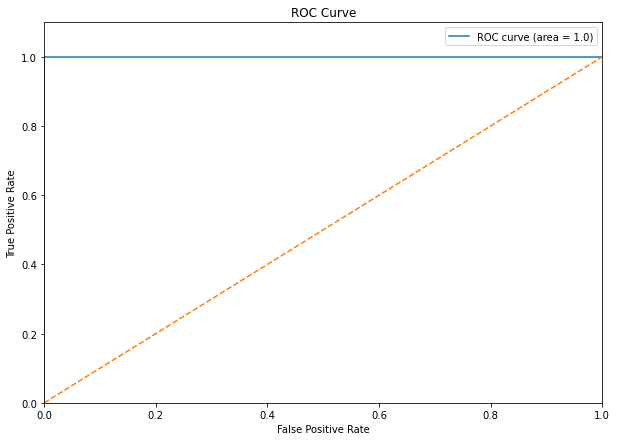

In [344]:
# create training dataset
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        if 'bending' in get_key(train_dict, df).split(' ')[0]:
            new_dict['activity'].append(1)
        else:
            new_dict['activity'].append(0)
    
df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
X_train = X_train[best_features]
y_train = np.array(df_train['activity']).reshape(-1)
model = LogisticRegression(solver='lbfgs', max_iter=10000, C=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("The Accuracy is: %f" %metrics.accuracy_score(y_train, y_pred))

print("The Confusion Matrix is:")
cm = metrics.confusion_matrix(y_train, y_pred)
print(cm)

# get the auc under the roc curve
auc = roc_auc_score(y_train, y_pred)
print('The AUC score is: '+ str(auc))

# get the roc curve
fpr, tpr, _ = roc_curve(y_train, y_pred)

# plot the roc curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.1f)' %auc)
plt.plot([0,1],[0,1], linestyle = '--')
# set title and axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])
# show the legend
plt.legend()
# show the plot
plt.show()

In [345]:
# report the coefficients and the pvalues
pval = f_classif(X_train,y_train)[1]
coef = pd.DataFrame({"Features":output[3],"Coefficient values":list(model.coef_[0]),'p-values':pval})
coef

,Features,Coefficient values,p-values
0,mean_avg_rss12,-5.188409,4.134957e-01
1,median_avg_rss12,2.443980,4.513780e-01
2,mean_avg_rss13,3.231969,7.132096e-02
3,median_avg_rss13,-4.152379,6.621379e-02
4,std_avg_rss13,-3.299425,3.693587e-03
5,median_var_rss13,-2.185153,2.364673e-02
6,mean_avg_rss23,6.454488,7.082167e-09
7,std_avg_rss23,5.095346,3.873863e-01
8,mean_var_rss23,-2.435276,1.348608e-02
9,median_var_rss23,-2.255267,1.230051e-02


I calculated the p-value using ANOVA, since ANOVA is used in the classification task with numerical inputs and qualitative target variable.

#### v. Test the classifier on the test set.

The Accuracy is: 1.000000
The Confusion Matrix is:
[[15  0]
 [ 0  4]]
The AUC score is: 1.0


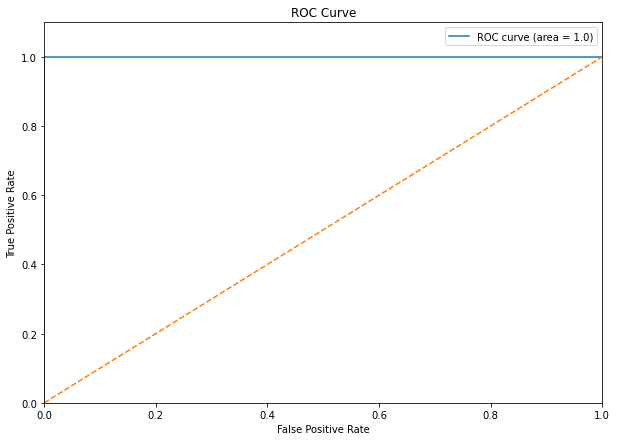

In [346]:
# create training datasets
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        if 'bending' in get_key(train_dict, df).split(' ')[0]:
            new_dict['activity'].append(1)
        else:
            new_dict['activity'].append(0)

df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
X_train = X_train[best_features]
y_train = np.array(df_train['activity']).reshape(-1)

# create test datasets
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in testdata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        if 'bending' in get_key(test_dict, df).split(' ')[0]:
            new_dict['activity'].append(1)
        else:
            new_dict['activity'].append(0)

df_test = pd.DataFrame(new_dict)
X_test = df_test[feature_lst]
X_test = X_test[best_features]
y_test = np.array(df_test['activity']).reshape(-1)

# test the classifier on the test set
model = LogisticRegression(solver='lbfgs', max_iter=10000, C=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("The Accuracy is: %f" %metrics.accuracy_score(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print("The Confusion Matrix is:")
print(cm)

# get the auc under the roc curve
auc = roc_auc_score(y_test, y_pred)
print('The AUC score is: '+ str(auc))

# get the roc curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# plot the roc curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.1f)' %auc)
plt.plot([0,1],[0,1], linestyle = '--')
# set title and axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])
# show the legend
plt.legend()
# show the plot
plt.show()

In [347]:
# calculate the coefficients and pvalues
pval = f_classif(X_train,y_train)[1]
coef = pd.DataFrame({"Features":output[3],"Coefficient values":list(model.coef_[0]),'p-values':pval})
coef

,Features,Coefficient values,p-values
0,mean_avg_rss12,-5.188409,4.134957e-01
1,median_avg_rss12,2.443980,4.513780e-01
2,mean_avg_rss13,3.231969,7.132096e-02
3,median_avg_rss13,-4.152379,6.621379e-02
4,std_avg_rss13,-3.299425,3.693587e-03
5,median_var_rss13,-2.185153,2.364673e-02
6,mean_avg_rss23,6.454488,7.082167e-09
7,std_avg_rss23,5.095346,3.873863e-01
8,mean_var_rss23,-2.435276,1.348608e-02
9,median_var_rss23,-2.255267,1.230051e-02


#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

In [348]:
# print the error message
try: 
    X = sm.add_constant(X_train)
    logit = sm.Logit(y_train, X)
    result = logit.fit()
    print(result.summary())
except Exception as e:
    print(e)

Perfect separation detected, results not available


Based on the error message printed above, the classes seem to be well-separated and cause instability in calculating logistic regression parameters, since when classes are perfectly separated, the coefficients go to infinity and become not applicable.

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters.

Yes, the classes are imbalanced, because we have 9 cases (bending) and 60 controls (non-bending).

The Accuracy is: 1.000000
The Confusion Matrix is:
[[27  0]
 [ 0  9]]
The AUC score is: 1.0


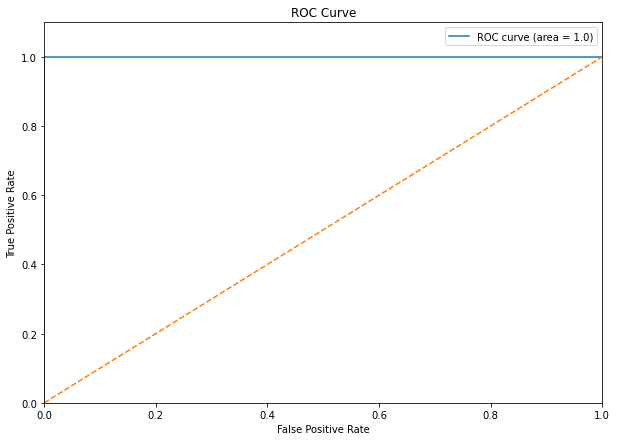

In [367]:
# create training datasets
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        if 'bending' in get_key(train_dict, df).split(' ')[0]:
            new_dict['activity'].append(1)
        else:
            new_dict['activity'].append(0)
    
df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
X_train = X_train[best_features]
y_train = np.array(df_train['activity']).reshape(-1)

# build random under sampler
model = LogisticRegression(solver='lbfgs', max_iter=10000, C=10000)
rus = RandomUnderSampler(sampling_strategy=0.33)
X, y = rus.fit_resample(X_train, y_train)
model.fit(X, y)
y_pred = model.predict(X)
print("The Accuracy is: %f" %metrics.accuracy_score(y, y_pred))

print("The Confusion Matrix is:")
cm = metrics.confusion_matrix(y, y_pred)
print(cm)

# get the auc under the roc curve
auc = roc_auc_score(y, y_pred)
print('The AUC score is: '+ str(auc))

# get the roc curve
fpr, tpr, _ = roc_curve(y, y_pred)
# plot the roc curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.1f)' %auc)
plt.plot([0,1],[0,1], linestyle = '--')
# set title and axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.10])
# show the legend
plt.legend()
# show the plot
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 2(a)iii  using L1-penalized logistic regression

In [350]:
# generate the process of L1-penalized logistic regression
def L1_penalized(result_dict_2, num_split):    
    # create training dataset
    new_dict = {}
    for f in features:
        new_dict['mean_'+f] = []
        new_dict['median_'+f] = []
        new_dict['std_'+f] = []
    new_dict['activity'] = []

    for df in traindata:
        df_split=np.array_split(df,num_split)
        for s in df_split:
            for f in features:
                new_dict["mean"+"_"+f].append(np.mean(s[f]))
                new_dict["median"+"_"+f].append(np.median(s[f]))
                new_dict["std"+"_"+f].append(s[f].std())
            if 'bending' in get_key(train_dict, df).split(' ')[0]:
                new_dict['activity'].append(1)
            else:
                new_dict['activity'].append(0)

    df_train = pd.DataFrame(new_dict)
    X_train = df_train[feature_lst]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train.values)
    X_train = pd.DataFrame(X_scaled, columns = X_train.columns)
    y_train = np.array(df_train['activity']).reshape(-1)
    
    # set classifier
    model = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', solver='liblinear', scoring='accuracy', 
                                 max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accuracy = model.score(X_train, y_train)
    scores = model.scores_
    cs_val = model.Cs_
    c_val = model.C_
    
    # get the index which has the max c value
    def get_index(cs_val, c_val):
        for i in range(len(cs_val)):
            if cs_val[i] == c_val:
                return i

    index = get_index(cs_val, c_val)
    cs_lst = []
    for i in range(len(scores[1])):
        score = scores[1][i][index]
        cs_lst.append(score)
    mean_cv_score = np.mean(cs_lst)
    
    # get the attributes
    result_dict_2[num_split] = []
    result_dict_2[num_split].append(c_val[0])
    result_dict_2[num_split].append(mean_cv_score)

In [351]:
# get attributes for each split
result_dict2 = {}
for i in num_split:
    L1_penalized(result_dict2, i)

In [352]:
# create output dataframe
output2 = pd.DataFrame(result_dict2).T.reset_index()
output2.columns = ['L', 'c_val', 'mean_cv_score']
output2['c_val'] = pd.to_numeric(output2['c_val'])
output2['mean_cv_score'] = pd.to_numeric(output2['mean_cv_score'])
output2

,L,c_val,mean_cv_score
0,1,1291.549665,0.914286
1,2,21.544347,0.935714
2,3,2.782559,0.888734
3,4,0.359381,0.880519
4,5,0.359381,0.907246
5,6,2.782559,0.893888
6,7,2.782559,0.900816
7,8,0.359381,0.896626
8,9,0.359381,0.896994
9,10,0.359381,0.891304


In [353]:
# print the output
output2 = output2.iloc[output2['mean_cv_score'].idxmax()]
optimal_L_2 = output2[0]
c_val = output2[1]
cv_score_2 = output2[2]
print('The best value of L is: '+ str(optimal_L_2))
print('The C value of the optimal L is: '+ str(c_val))
print('The optimal cv score is: '+str(cv_score_2))

The best value of L is: 2.0
The C value of the optimal L is: 21.54434690031882
The optimal cv score is: 0.9357142857142857


<u> The best pair of (L, C) is (2, 21.54434690031882) <u>

#### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Compared with the variable selection using p-values, the L1-penalized logistic regression performs better and it is also easier to implement? From my experiment, the L1-penalized model has a slightly better cross validation score than that of the feature selecting using p-values. Also, it is easier to implement because it does not require us to mannually select features and it does the selection for us automatically. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.

In [354]:
# generate the process of L1-penalized multinomial regression 
def L1_penalized_multi(result_dict_3, num_split):  
    # create training dataset
    new_dict = {}
    for f in features:
        new_dict['mean_'+f] = []
        new_dict['median_'+f] = []
        new_dict['std_'+f] = []
    new_dict['activity'] = []

    for df in traindata:
        df_split=np.array_split(df,num_split)
        for s in df_split:
            for f in features:
                new_dict["mean"+"_"+f].append(np.mean(s[f]))
                new_dict["median"+"_"+f].append(np.median(s[f]))
                new_dict["std"+"_"+f].append(s[f].std())
            new_dict['activity'].append(get_key(train_dict, df).split(' ')[0])
                
    df_train = pd.DataFrame(new_dict)
    X_train = df_train[feature_lst]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train.values)
    X_train = pd.DataFrame(X_scaled, columns = X_train.columns)
    y_train = np.array(df_train['activity']).reshape(-1)
    
    # fit the model
    model = LogisticRegressionCV(cv=StratifiedKFold(5), penalty='l1', solver='saga', scoring='accuracy', 
                                 max_iter=10000, multi_class='multinomial')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accuracy = model.score(X_train, y_train)
    scores = model.scores_
    cs_val = model.Cs_
    c_val = model.C_
    
    # get the index which has the max c value
    def get_index(cs_val, c_val):
        for i in range(len(cs_val)):
            if cs_val[i] == c_val:
                return i

    index = get_index(cs_val, c_val[0])
    cs_lst = []
    for i in range(len(scores['bending1'])):
        score = scores['bending1'][i][index]
        cs_lst.append(score)
    mean_cv_score = np.mean(cs_lst)
    
    # get the attributes
    result_dict_3[num_split] = []
    result_dict_3[num_split].append(c_val[0])
    result_dict_3[num_split].append(mean_cv_score)

In [355]:
import warnings
warnings.filterwarnings('ignore')

In [356]:
# get attributes for each split
result_dict3 = {}
for i in num_split:
    L1_penalized_multi(result_dict3, i)

In [357]:
# create output dataframe
output3 = pd.DataFrame(result_dict3).T.reset_index()
output3.columns = ['L', 'c_val', 'mean_cv_score']
output3['c_val'] = pd.to_numeric(output3['c_val'])
output3['mean_cv_score'] = pd.to_numeric(output3['mean_cv_score'])
output3

,L,c_val,mean_cv_score
0,1,21.544347,0.900000
1,2,21.544347,0.861905
2,3,21.544347,0.869570
3,4,10000.000000,0.855065
4,5,166.810054,0.849275
5,6,21.544347,0.833382
6,7,2.782559,0.819910
7,8,166.810054,0.833333
8,9,1291.549665,0.826077
9,10,2.782559,0.814493


In [358]:
# print the output
output3 = output3.iloc[output3['mean_cv_score'].idxmax()]
optimal_L_3 = output3[0]
c_val = output3[1]
cv_score_3 = output3[2]
print('The best value of L is: '+ str(optimal_L_3))
print('The C value of the optimal L is: '+ str(c_val))
print('The optimal cv score is: '+str(cv_score_3))

The best value of L is: 1.0
The C value of the optimal L is: 21.54434690031882
The optimal cv score is: 0.9


<u> The best pair of (L, C) is (1, 21.54434690031882) <u>                                             

The test error is: 0.157895
The accuracy is: 0.842105
The confusion matrix is: 
[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]


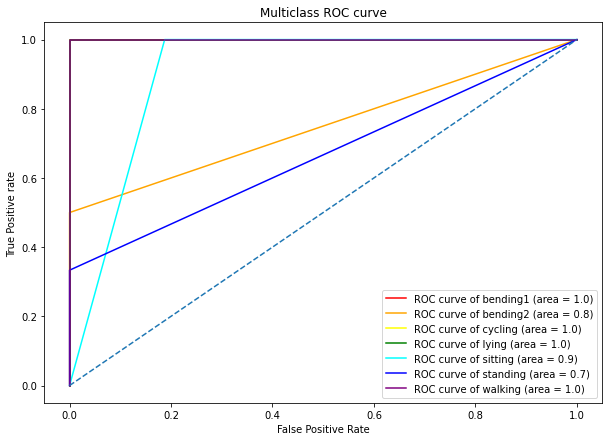

In [373]:
# create training dataset
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(train_dict, df).split(' ')[0])

df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(X_scaled, columns = X_train.columns)
y_train = np.array(df_train['activity'])

# create testing dataset
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in testdata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(test_dict, df).split(' ')[0])

df_test = pd.DataFrame(new_dict)
X_test = df_test[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_test.values)
X_test = pd.DataFrame(X_scaled, columns = X_test.columns)
y_test = np.array(df_test['activity'])

# build model and test on test set
model = LogisticRegression(C=21.54434690031882, penalty='l1', solver='saga',max_iter=10000, multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy, error and confusion matrix
print("The test error is: %f" %error)
print("The accuracy is: %f" %accuracy)
cm = confusion_matrix(y_test, y_pred)
print("The confusion matrix is: ")
print(cm)

def be_binary(label, y_test, y_pred):
    y_test_new = []
    y_pred_new = []
    for i in y_test:
        if i == label:
            y_test_new.append(1)
        else:
            y_test_new.append(0)
    for i in y_pred:
        if i == label:
            y_pred_new.append(1)
        else:
            y_pred_new.append(0)
    return y_test_new, y_pred_new

y_test_lst = []
y_pred_lst = []
y_test_lst.append(be_binary('bending1', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending1', y_test, y_pred)[1])
y_test_lst.append(be_binary('bending2', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending2', y_test, y_pred)[1])
y_test_lst.append(be_binary('cycling', y_test, y_pred)[0])
y_pred_lst.append(be_binary('cycling', y_test, y_pred)[1])
y_test_lst.append(be_binary('lying', y_test, y_pred)[0])
y_pred_lst.append(be_binary('lying', y_test, y_pred)[1])
y_test_lst.append(be_binary('sitting', y_test, y_pred)[0])
y_pred_lst.append(be_binary('sitting', y_test, y_pred)[1])
y_test_lst.append(be_binary('standing', y_test, y_pred)[0])
y_pred_lst.append(be_binary('standing', y_test, y_pred)[1])
y_test_lst.append(be_binary('walking', y_test, y_pred)[0])
y_pred_lst.append(be_binary('walking', y_test, y_pred)[1])


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_lst[i], y_pred_lst[i])
    roc_auc[i] = roc_auc_score(y_test_lst[i], y_pred_lst[i])
    

plt.figure(figsize=(10, 7))
plt.plot(fpr[0], tpr[0], color='red', label='ROC curve of bending1 (area = %0.1f)' %roc_auc[0])
plt.plot(fpr[1], tpr[1], color='orange', label='ROC curve of bending2 (area = %0.1f)' %roc_auc[1])
plt.plot(fpr[2], tpr[2], color='yellow', label='ROC curve of cycling (area = %0.1f)' %roc_auc[2])
plt.plot(fpr[3], tpr[3], color='green', label='ROC curve of lying (area = %0.1f)' %roc_auc[3])
plt.plot(fpr[4], tpr[4], color='cyan', label='ROC curve of sitting (area = %0.1f)' %roc_auc[4])
plt.plot(fpr[5], tpr[5], color='blue', label='ROC curve of standing (area = %0.1f)' %roc_auc[5])
plt.plot(fpr[6], tpr[6], color='purple', label='ROC curve of walking (area = %0.1f)' %roc_auc[6])
plt.plot([0,1],[0,1], linestyle = '--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()

#### ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

The test error is: 0.421053
The accuracy is: 0.578947
The confusion matrix is: 
[[2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 3 0 0]
 [0 0 3 0 0 0 0]]


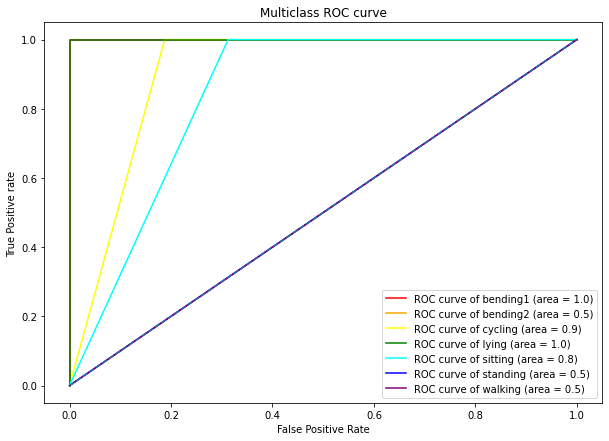

In [374]:
# create training datasets
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(train_dict, df).split(' ')[0])

df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(X_scaled, columns = X_train.columns)
y_train = np.array(df_train['activity'])

# create test datasets
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in testdata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(test_dict, df).split(' ')[0])

df_test = pd.DataFrame(new_dict)
X_test = df_test[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_test.values)
X_test = pd.DataFrame(X_scaled, columns = X_test.columns)
y_test = np.array(df_test['activity'])

# build model and test on test set
gaussian= GaussianNB() 
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy, error and confusion matrix
print("The test error is: %f" %error)
print("The accuracy is: %f" %accuracy)
cm = confusion_matrix(y_test, y_pred)
print("The confusion matrix is: ")
print(cm)

def be_binary(label, y_test, y_pred):
    y_test_new = []
    y_pred_new = []
    for i in y_test:
        if i == label:
            y_test_new.append(1)
        else:
            y_test_new.append(0)
    for i in y_pred:
        if i == label:
            y_pred_new.append(1)
        else:
            y_pred_new.append(0)
    return y_test_new, y_pred_new

y_test_lst = []
y_pred_lst = []
y_test_lst.append(be_binary('bending1', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending1', y_test, y_pred)[1])
y_test_lst.append(be_binary('bending2', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending2', y_test, y_pred)[1])
y_test_lst.append(be_binary('cycling', y_test, y_pred)[0])
y_pred_lst.append(be_binary('cycling', y_test, y_pred)[1])
y_test_lst.append(be_binary('lying', y_test, y_pred)[0])
y_pred_lst.append(be_binary('lying', y_test, y_pred)[1])
y_test_lst.append(be_binary('sitting', y_test, y_pred)[0])
y_pred_lst.append(be_binary('sitting', y_test, y_pred)[1])
y_test_lst.append(be_binary('standing', y_test, y_pred)[0])
y_pred_lst.append(be_binary('standing', y_test, y_pred)[1])
y_test_lst.append(be_binary('walking', y_test, y_pred)[0])
y_pred_lst.append(be_binary('walking', y_test, y_pred)[1])


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_lst[i], y_pred_lst[i])
    roc_auc[i] = roc_auc_score(y_test_lst[i], y_pred_lst[i]) 
    

plt.figure(figsize=(10, 7))
plt.plot(fpr[0], tpr[0], color='red', label='ROC curve of bending1 (area = %0.1f)' %roc_auc[0])
plt.plot(fpr[1], tpr[1], color='orange', label='ROC curve of bending2 (area = %0.1f)' %roc_auc[1])
plt.plot(fpr[2], tpr[2], color='yellow', label='ROC curve of cycling (area = %0.1f)' %roc_auc[2])
plt.plot(fpr[3], tpr[3], color='green', label='ROC curve of lying (area = %0.1f)' %roc_auc[3])
plt.plot(fpr[4], tpr[4], color='cyan', label='ROC curve of sitting (area = %0.1f)' %roc_auc[4])
plt.plot(fpr[5], tpr[5], color='blue', label='ROC curve of standing (area = %0.1f)' %roc_auc[5])
plt.plot(fpr[6], tpr[6], color='purple', label='ROC curve of walking (area = %0.1f)' %roc_auc[6])
plt.plot([0,1],[0,1], linestyle = '--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()

The test error is: 0.315789
The accuracy is: 0.684211
The confusion matrix is: 
[[0 0 0 0 2 0 0]
 [0 0 0 0 2 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]


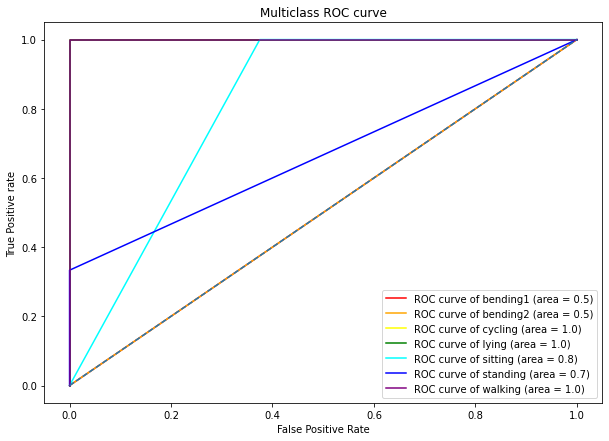

In [372]:
# create training dataset
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in traindata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(train_dict, df).split(' ')[0])

df_train = pd.DataFrame(new_dict)
X_train = df_train[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(X_scaled, columns = X_train.columns)
y_train = np.array(df_train['activity'])

# create test dataset
new_dict = {}
for f in features:
    new_dict['mean_'+f] = []
    new_dict['median_'+f] = []
    new_dict['std_'+f] = []
new_dict['activity'] = []
    
for df in testdata:
    df_split=np.array_split(df,1)
    for s in df_split:
        for f in features:
            new_dict["mean"+"_"+f].append(np.mean(s[f]))
            new_dict["median"+"_"+f].append(np.median(s[f]))
            new_dict["std"+"_"+f].append(s[f].std())
        new_dict['activity'].append(get_key(test_dict, df).split(' ')[0])
        
df_test = pd.DataFrame(new_dict)
X_test = df_test[feature_lst]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_test.values)
X_test = pd.DataFrame(X_scaled, columns = X_test.columns)
y_test = np.array(df_test['activity'])

# build model and test on test set
multi = MultinomialNB() 
multi.fit(X_train, y_train)
y_pred = multi.predict(X_test)
error = 1 - accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy, error and confusion matrix
print("The test error is: %f" %error)
print("The accuracy is: %f" %accuracy)
cm = confusion_matrix(y_test, y_pred)
print("The confusion matrix is: ")
print(cm)

def be_binary(label, y_test, y_pred):
    y_test_new = []
    y_pred_new = []
    for i in y_test:
        if i == label:
            y_test_new.append(1)
        else:
            y_test_new.append(0)
    for i in y_pred:
        if i == label:
            y_pred_new.append(1)
        else:
            y_pred_new.append(0)
    return y_test_new, y_pred_new

y_test_lst = []
y_pred_lst = []
y_test_lst.append(be_binary('bending1', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending1', y_test, y_pred)[1])
y_test_lst.append(be_binary('bending2', y_test, y_pred)[0])
y_pred_lst.append(be_binary('bending2', y_test, y_pred)[1])
y_test_lst.append(be_binary('cycling', y_test, y_pred)[0])
y_pred_lst.append(be_binary('cycling', y_test, y_pred)[1])
y_test_lst.append(be_binary('lying', y_test, y_pred)[0])
y_pred_lst.append(be_binary('lying', y_test, y_pred)[1])
y_test_lst.append(be_binary('sitting', y_test, y_pred)[0])
y_pred_lst.append(be_binary('sitting', y_test, y_pred)[1])
y_test_lst.append(be_binary('standing', y_test, y_pred)[0])
y_pred_lst.append(be_binary('standing', y_test, y_pred)[1])
y_test_lst.append(be_binary('walking', y_test, y_pred)[0])
y_pred_lst.append(be_binary('walking', y_test, y_pred)[1])


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_lst[i], y_pred_lst[i])
    roc_auc[i] = roc_auc_score(y_test_lst[i], y_pred_lst[i]) 
    

plt.figure(figsize=(10, 7))
plt.plot(fpr[0], tpr[0], color='red', label='ROC curve of bending1 (area = %0.1f)' %roc_auc[0])
plt.plot(fpr[1], tpr[1], color='orange', label='ROC curve of bending2 (area = %0.1f)' %roc_auc[1])
plt.plot(fpr[2], tpr[2], color='yellow', label='ROC curve of cycling (area = %0.1f)' %roc_auc[2])
plt.plot(fpr[3], tpr[3], color='green', label='ROC curve of lying (area = %0.1f)' %roc_auc[3])
plt.plot(fpr[4], tpr[4], color='cyan', label='ROC curve of sitting (area = %0.1f)' %roc_auc[4])
plt.plot(fpr[5], tpr[5], color='blue', label='ROC curve of standing (area = %0.1f)' %roc_auc[5])
plt.plot(fpr[6], tpr[6], color='purple', label='ROC curve of walking (area = %0.1f)' %roc_auc[6])
plt.plot([0,1],[0,1], linestyle = '--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()

#### iii. Which method is better for multi-class classification in this problem?

Based on the test errors from three models above, the L1-penalized multinomial regression performs the best because it has the highest accuracy and the lowest test error. However, the reason that L-penalized multinomial regression model has the best performance might be that I have not fine-tuned the other two Naive Bayes classifiers. 

## 3. ISLR, 4.8.3

Now by Bayes's Theorem we have the formula: <br>
## $ p_{k}\left ( x \right ) = \frac{\pi _{k} \frac{1}{\sqrt{2\pi}\sigma _{k}}exp\left ( -\frac{1}{2\sigma ^{2}}\left ( x-\mu _{k} \right )^{2} \right )}{\sum_{l=1}^{K}\pi _{l} \frac{1}{\sqrt{2\pi}\sigma _{l}}exp\left ( -\frac{1}{2\sigma ^{2}}\left ( x-\mu _{l} \right )^{2} \right )} $
<br> We need the log to be maximized if we want the formula to be maximized.
<br> 
### $ log(\pi _{k}\frac{1}{\sqrt{2\pi }\sigma _{k}} exp(-\frac{1}{2\sigma ^{2}_{k}}(x-\mu _{k})^{2})) = log(\pi _{k}) - log(\sqrt{2 \pi}\sigma _{k}) - \frac{1}{2\sigma ^{2} _{k}}(x-\mu _{k}) ^{2} $<br>
### $ = constant + log(\frac{\pi _{k}}{\sigma _{k}}) - \frac{x ^{2}}{2 \sigma ^{2}_{k}} + \frac{\mu _{k}x}{\sigma ^{2} _{k}} - \frac{\mu ^{2}_{k}}{2\sigma^{2}_{k}} $
<br> Let 
### $ \sigma _{k} = log(\frac{\pi _{k}}{\sigma _{k}}) - \frac{x ^{2}}{2 \sigma ^{2}_{k}} + \frac{\mu _{k}x}{\sigma ^{2} _{k}} - \frac{\mu ^{2}_{k}}{2\sigma^{2}_{k}} $
then we can see the Bayes classifier is not linear and in fact quadratic.

## 4. ISLR 4.8.7

We have the prior probability $ \pi _{1} = 0.8 $ and $ \pi _{2} = 0.2 $, then
### $ p_{1}(x=4) = \frac{\pi _{1}f_{1}(x)}{\pi _{1}f_{1}(x)+\pi _{2}f_{2}(x)} = \frac{0.8f_{1}(4)}{0.8f_{1}(4)+0.2f_{2}(4)}\approx \frac{0.8\times0.04033}{0.8\times0.04033+0.2\times0.05324}\approx 0.7518525 $ 
<br> Thus, there is a 75.19% chance that a company will issue a dividend this year given that its percentage profit was  𝑋=4 last year.